In [11]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split

# ========================================================
# ⚙️ CẤU HÌNH 
# ========================================================
# 1. Nguồn Labels 
LABEL_DIR = "/kaggle/input/go-cafa6"
# 2. Nguồn Embeddings
EMBED_DIR = "/kaggle/input/cafa6-embeds"
TRAIN_IDS_FILE = os.path.join(EMBED_DIR, "train_ids.txt")
# 3. Chia tập
VAL_SIZE = 0.1  # 10% cho Validation
SEED = 42

# =========================================================
# HÀM XỬ LÝ CHÍNH: TẠO TARGETS & SPLIT (CHẠY 3 LẦN)
# =========================================================

def process_and_split(coverage_name):
    """
    Thực hiện toàn bộ pipeline từ Load Vocab đến Split cho một mức coverage cụ thể.
    coverage_name là 'C90', 'C95', hoặc 'C99'.
    """
    # 1. DYNAMIC FILE PATHS (Dựa trên tên coverage_name và chiến lược '_remove')
    TRAIN_LABEL_FILE = os.path.join(LABEL_DIR, f"train_data_{coverage_name}_remove.tsv")
    VOCAB_FILE = os.path.join(LABEL_DIR, f"vocab_{coverage_name}_remove.csv")
    
    # 2. OUTPUT FILES
    OUTPUT_PKL = f"train_targets_{coverage_name}.pkl"
    TRAIN_OUT_IDS = f"train_ids_{coverage_name}_split.npy"
    VAL_OUT_IDS = f"val_ids_{coverage_name}_split.npy"

    print(f"\n========================================================")
    print(f"🚀 PROCESSING SET: {coverage_name} ({VAL_SIZE*100:.0f}% Validation)")
    print(f"========================================================")

    # BƯỚC 1: LOAD VOCAB & TẠO MAP (TERM -> INDEX)
    print(f"1. Loading Vocab từ {VOCAB_FILE}...")
    vocab_df = pd.read_csv(VOCAB_FILE)
    term_to_idx = {term: i for i, term in enumerate(vocab_df['term'])}
    num_classes = len(term_to_idx)
    print(f"   - Số lượng nhãn (Classes): {num_classes}")

    # BƯỚC 2: LOAD EMBEDDING PROTEIN IDs (FILTER INPUT)
    print(f"\n2. Loading Embedding IDs từ {TRAIN_IDS_FILE}...")
    if TRAIN_IDS_FILE.endswith('.npy'):
        embed_protein_ids = np.load(TRAIN_IDS_FILE)
    else:
        with open(TRAIN_IDS_FILE, 'r') as f:
            embed_protein_ids = [line.strip() for line in f if line.strip()]
    
    valid_proteins_set = set(embed_protein_ids)
    print(f"   - Số lượng Protein có Embeddings: {len(valid_proteins_set):,}")

    # BƯỚC 3: LOAD LABELS & FILTER & MAP
    print(f"\n3. Loading & Processing Labels từ {TRAIN_LABEL_FILE}...")
    df = pd.read_csv(TRAIN_LABEL_FILE, sep="\t", names=["protein", "term", "aspect"])
    
    df = df[df['protein'].isin(valid_proteins_set)]
    df = df[df['term'].isin(term_to_idx)]
    
    print(f"   - Số proteins unique hợp lệ: {df['protein'].nunique():,}")

    # Chuyển đổi: GO Term -> Index (Số nguyên)
    df['label_idx'] = df['term'].map(term_to_idx)

    # BƯỚC 4: TẠO MULTI-HOT DICTIONARY
    print("\n4. Grouping by Protein (Creating Dictionary)...")
    labels_dict = df.groupby('protein')['label_idx'].apply(list).to_dict()

    with open(OUTPUT_PKL, 'wb') as f:
        pickle.dump(labels_dict, f)
    print(f"   ✅ Đã lưu targets: {OUTPUT_PKL}")

    # BƯỚC 5: CHIA TRAIN / VALIDATION (SPLIT)
    print(f"\n5. Splitting Train/Val...")
    all_proteins = np.array(list(labels_dict.keys()))

    train_ids, val_ids = train_test_split(
        all_proteins, 
        test_size=VAL_SIZE, 
        random_state=SEED,
        shuffle=True
    )

    # Lưu danh sách ID ra file .npy
    np.save(TRAIN_OUT_IDS, train_ids)
    np.save(VAL_OUT_IDS, val_ids)

    print(f"   ✅ Đã lưu file IDs: {TRAIN_OUT_IDS} và {VAL_OUT_IDS}")
    print(f"   - Train Samples: {len(train_ids):,} | Val Samples: {len(val_ids):,}")


# =========================================================
# THỰC THI CHƯƠNG TRÌNH CHÍNH (TẠO 3 BỘ)
# =========================================================
print("🚀 BẮT ĐẦU TẠO 3 BỘ DỮ LIỆU ĐẦU RA...")

for name in ['C90', 'C95', 'C99']:
    process_and_split(name)

print("\n" + "="*50)
print("✅ HOÀN TẤT! ĐÃ TẠO THÀNH CÔNG 3 BỘ DỮ LIỆU ĐẦU RA.")

🚀 BẮT ĐẦU TẠO 3 BỘ DỮ LIỆU ĐẦU RA...

🚀 PROCESSING SET: C90 (10% Validation)
1. Loading Vocab từ /kaggle/input/go-cafa6/vocab_C90_remove.csv...
   - Số lượng nhãn (Classes): 3375

2. Loading Embedding IDs từ /kaggle/input/cafa6-embeds/train_ids.txt...
   - Số lượng Protein có Embeddings: 82,404

3. Loading & Processing Labels từ /kaggle/input/go-cafa6/train_data_C90_remove.tsv...
   - Số proteins unique hợp lệ: 82,401

4. Grouping by Protein (Creating Dictionary)...
   ✅ Đã lưu targets: train_targets_C90.pkl

5. Splitting Train/Val...
   ✅ Đã lưu file IDs: train_ids_C90_split.npy và val_ids_C90_split.npy
   - Train Samples: 74,160 | Val Samples: 8,241

🚀 PROCESSING SET: C95 (10% Validation)
1. Loading Vocab từ /kaggle/input/go-cafa6/vocab_C95_remove.csv...
   - Số lượng nhãn (Classes): 6413

2. Loading Embedding IDs từ /kaggle/input/cafa6-embeds/train_ids.txt...
   - Số lượng Protein có Embeddings: 82,404

3. Loading & Processing Labels từ /kaggle/input/go-cafa6/train_data_C95_remove.t

In [10]:
import pickle
import numpy as np
import pandas as pd
import os

# Cấu hình đường dẫn
TARGET_PKL = "/kaggle/working/train_targets_C95.pkl"

# 1. Load targets dictionary
print(f"Đang đọc file targets: {TARGET_PKL}...")
with open(TARGET_PKL, 'rb') as f:
    labels_dict = pickle.load(f)

# 2. Load Vocab (để dịch index)
print(f"Đang đọc file vocab: {VOCAB_FILE}...")
vocab_df = pd.read_csv(VOCAB_FILE)
term_list = vocab_df['term'].tolist()
aspect_list = vocab_df['aspect'].tolist()

# 3. Lấy mẫu và kiểm tra
sample_id = list(labels_dict.keys())[0]
sample_indices = labels_dict[sample_id]
num_classes = len(term_list)

print("\n--- KIỂM TRA MẪU ---")
print(f"Protein ID: {sample_id}")
print(f"Số lượng nhãn dương: {len(sample_indices)}")
print(f"Total classes: {num_classes}")

# 4. Dịch các chỉ số thành GO Term và Aspect
print("\nDanh sách nhãn GO (dịch từ Index):")
for idx in sample_indices:
    term = term_list[idx]
    aspect = aspect_list[idx]
    print(f"  - Index {idx:<5} -> {term:<12} (Aspect: {aspect})")

# 5. Kiểm tra dạng Multi-hot (chuyển đổi)
# Tạo vector 0/1 dài 6416 số
multi_hot_vector = np.zeros(num_classes, dtype=np.int8)
multi_hot_vector[sample_indices] = 1

print(f"\nVector Multi-hot (ví dụ): {multi_hot_vector[:10]}...")

multi_hot_vector.shape

Đang đọc file targets: /kaggle/working/train_targets_C95.pkl...
Đang đọc file vocab: /kaggle/input/go-cafa6/vocab_C95_remove.csv...

--- KIỂM TRA MẪU ---
Protein ID: A0A023FBW4
Số lượng nhãn dương: 4
Total classes: 6413

Danh sách nhãn GO (dịch từ Index):
  - Index 3     -> GO:0005488   (Aspect: MFO)
  - Index 4449  -> GO:0019956   (Aspect: MFO)
  - Index 2121  -> GO:0019955   (Aspect: MFO)
  - Index 6     -> GO:0005515   (Aspect: MFO)

Vector Multi-hot (ví dụ): [0 0 0 1 0 0 1 0 0 0]...


(6413,)

📊 PHÂN TÍCH TAXONOMY (FINAL REPORT VERSION)

✅ Tổng Taxa: 1381
✅ Vùng học tốt (Freq >= 10): 140
✅ Vùng chết (Freq < 10): 1241

--- TẠO MAPPING TAXONOMY CHO TRAIN ---
K_FINAL (freq ≥ 10) = 140
UNK_IDX = 140

--- KẾT QUẢ LƯU FILE ---
   - Số lớp Taxonomy (kể cả UNK): 141
   - Số Protein rơi vào UNK     : 2,719
   - Coverage taxonomy riêng   : 96.70%
   - File mapping đã lưu       : /kaggle/working/taxon_mapping_K140.pkl

--- K THEO NGƯỠNG FREQ >= 10 ---
Tổng số taxonomy           : 1381
K (freq ≥ 10)      : 140
Dead-zone (freq < 10) : 1241 (89.86%)


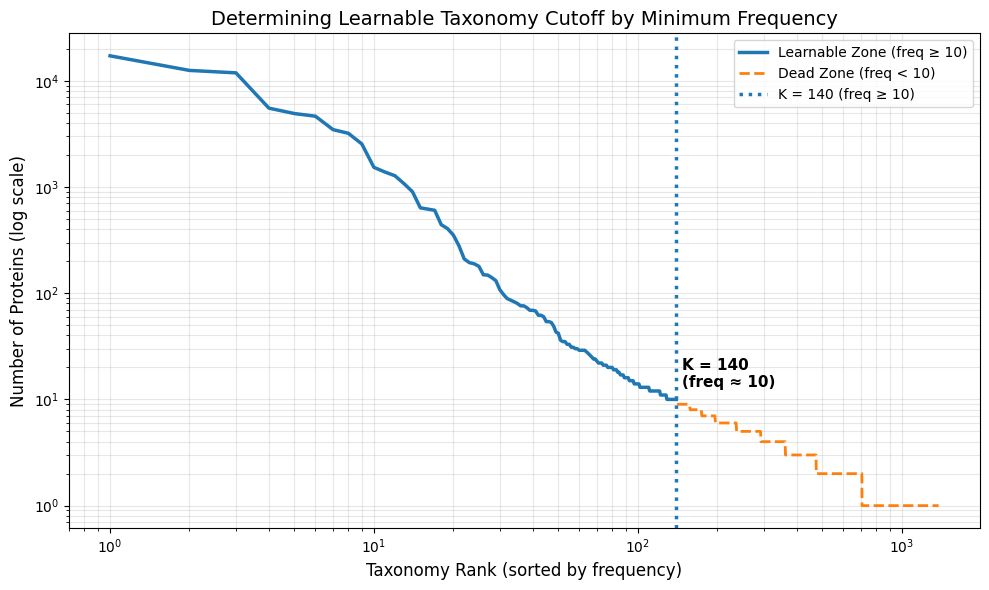

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import pickle

# ================================
# CẤU HÌNH
# ================================
CONFIG = {
    "TAXON_FILE": "/kaggle/input/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv",
    "MIN_SAMPLES_REQUIRED": 10,
    "OUTPUT_PKL": "/kaggle/working/taxon_mapping_K140.pkl"
}

def analyze_for_report_final():
    print("📊 PHÂN TÍCH TAXONOMY (FINAL REPORT VERSION)\n")
    
    # 1. LOAD DATA
    try:
        df = pd.read_csv(CONFIG["TAXON_FILE"], sep="\t", header=None, names=["Protein", "Taxon"], dtype=str)
    except:
        # Tạo dummy data nếu không có file thật để test code vẽ
        print("⚠️ Warning: Không tìm thấy file, tạo dữ liệu giả lập để demo...")
        np.random.seed(42)
        counts = np.random.zipf(1.5, 82000)
        df = pd.DataFrame({'Taxon': counts.astype(str)})

    tax_counts = df["Taxon"].value_counts()
    total_proteins = len(df)
    total_taxa = len(tax_counts)
    
    # 2. CUMULATIVE COVERAGE
    sorted_counts = tax_counts.sort_values(ascending=False)
    cumulative_sum = sorted_counts.cumsum()
    cumulative_percent = cumulative_sum / total_proteins * 100
    
    # Tìm K95, K99
    K95 = np.searchsorted(cumulative_percent, 95) + 1
    K99 = np.searchsorted(cumulative_percent, 99) + 1
    
    # Tính toán vùng chết
    min_freq = CONFIG["MIN_SAMPLES_REQUIRED"]
    dead_zone_count = (tax_counts < min_freq).sum()
    valid_learning_zone = total_taxa - dead_zone_count
    
    print(f"✅ Tổng Taxa: {total_taxa}")
    print(f"✅ Vùng học tốt (Freq >= {min_freq}): {valid_learning_zone}")
    print(f"✅ Vùng chết (Freq < {min_freq}): {dead_zone_count}")

    # =================================================================
    # 2. TẠO VÀ LƯU FILE MAPPING (K = số taxon có freq ≥ 10)
    # =================================================================
    
    min_freq = CONFIG["MIN_SAMPLES_REQUIRED"]
    
    # ✅ Lấy top taxon theo ngưỡng freq ≥ 10
    top_taxa_series = tax_counts[tax_counts >= min_freq]
    K_FINAL = len(top_taxa_series)   # = 140 (theo kết quả của bạn)
    
    # ✅ Gán UNK index là vị trí cuối
    UNK_IDX = K_FINAL
    
    print("\n--- TẠO MAPPING TAXONOMY CHO TRAIN ---")
    print(f"K_FINAL (freq ≥ {min_freq}) = {K_FINAL}")
    print(f"UNK_IDX = {UNK_IDX}")
    
    # ✅ Map: Taxon ID -> index
    taxon_to_idx = {tid: i for i, tid in enumerate(top_taxa_series.index)}
    
    # ✅ Map: Protein ID -> Taxon index (hoặc UNK)
    prot_to_taxon_idx = {
        pid: taxon_to_idx.get(tid, UNK_IDX)
        for pid, tid in zip(df["Protein"], df["Taxon"])
    }
    
    # ✅ Gói dữ liệu để lưu
    data_to_save = {
        "taxon_to_idx": taxon_to_idx,
        "prot_to_taxon_idx": prot_to_taxon_idx,
        "num_taxa_classes": K_FINAL + 1,   # +1 cho UNK
        "min_freq_cutoff": min_freq
    }
    
    # ✅ LƯU FILE
    with open(CONFIG["OUTPUT_PKL"], "wb") as f:
        pickle.dump(data_to_save, f)
    
    # ✅ THỐNG KÊ COVERAGE
    unk_count = list(prot_to_taxon_idx.values()).count(UNK_IDX)
    coverage = (total_proteins - unk_count) / total_proteins * 100
    
    print("\n--- KẾT QUẢ LƯU FILE ---")
    print(f"   - Số lớp Taxonomy (kể cả UNK): {data_to_save['num_taxa_classes']:,}")
    print(f"   - Số Protein rơi vào UNK     : {unk_count:,}")
    print(f"   - Coverage taxonomy riêng   : {coverage:.2f}%")
    print(f"   - File mapping đã lưu       : {CONFIG['OUTPUT_PKL']}")
    
    # =========================
    # BIỂU ĐỒ DUY NHẤT: XÁC ĐỊNH K THEO NGƯỠNG FREQ >= 10
    # =========================
    
    min_freq = CONFIG["MIN_SAMPLES_REQUIRED"]  # = 10
    
    sorted_counts = tax_counts.sort_values(ascending=False)
    freqs = sorted_counts.values
    ranks = np.arange(1, len(freqs) + 1)
    
    # ✅ K chính là số taxonomy có freq >= 10
    K_freq = (freqs >= min_freq).sum()
    dead_zone_count = len(freqs) - K_freq
    
    print("\n--- K THEO NGƯỠNG FREQ >= 10 ---")
    print(f"Tổng số taxonomy           : {len(freqs)}")
    print(f"K (freq ≥ {min_freq})      : {K_freq}")
    print(f"Dead-zone (freq < {min_freq}) : {dead_zone_count} ({dead_zone_count/len(freqs)*100:.2f}%)")
    
    plt.figure(figsize=(10, 6))
    
    # Vùng học được (freq ≥ 10)
    plt.loglog(
        ranks[:K_freq],
        freqs[:K_freq],
        linewidth=2.5,
        label=f"Learnable Zone (freq ≥ {min_freq})"
    )
    
    # Vùng dead-zone (freq < 10)
    plt.loglog(
        ranks[K_freq:],
        freqs[K_freq:],
        linewidth=2,
        linestyle="--",
        label=f"Dead Zone (freq < {min_freq})"
    )
    
    # ✅ ĐƯỜNG DỌC CẮT K THEO NGƯỠNG 10 (QUAN TRỌNG NHẤT)
    plt.axvline(
        x=K_freq,
        linestyle=":",
        linewidth=2.5,
        label=f"K = {K_freq} (freq ≥ {min_freq})"
    )
    
    # Ghi chú cho đường dọc
    plt.text(
        K_freq * 1.05,
        freqs[K_freq-1] * 1.3,
        f"K = {K_freq}\n(freq ≈ {int(freqs[K_freq-1])})",
        fontsize=11,
        fontweight="bold"
    )
    
    # Nhãn & tiêu đề chuẩn báo cáo
    plt.title("Determining Learnable Taxonomy Cutoff by Minimum Frequency", fontsize=14)
    plt.xlabel("Taxonomy Rank (sorted by frequency)", fontsize=12)
    plt.ylabel("Number of Proteins (log scale)", fontsize=12)
    
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    analyze_for_report_final()

In [2]:
import pickle
import pandas as pd
from collections import Counter

# =========================
# CẤU HÌNH
# =========================
MAPPING_FILE = "/kaggle/working/taxon_mapping_K140.pkl"
TAXON_FILE = "/kaggle/input/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv"

def verify_taxonomy_mapping():
    print("🔍 KIỂM TRA FILE TAXONOMY MAPPING (K=140)\n")

    # =========================
    # 1. LOAD FILE PKL
    # =========================
    with open(MAPPING_FILE, "rb") as f:
        data = pickle.load(f)

    taxon_to_idx = data["taxon_to_idx"]
    prot_to_taxon_idx = data["prot_to_taxon_idx"]
    num_taxa_classes = data["num_taxa_classes"]
    min_freq_cutoff = data["min_freq_cutoff"]

    print("✅ Load file mapping thành công!")
    print(f"   - Số class taxonomy (kể cả UNK): {num_taxa_classes}")
    print(f"   - Ngưỡng min_freq_cutoff      : {min_freq_cutoff}")
    print(f"   - Số taxonomy riêng           : {num_taxa_classes - 1}")

    UNK_IDX = num_taxa_classes - 1

    # =========================
    # 2. LOAD FILE GỐC
    # =========================
    df = pd.read_csv(
        TAXON_FILE,
        sep="\t",
        header=None,
        names=["Protein", "Taxon"],
        dtype=str
    )

    total_proteins = len(df)
    unique_proteins = df["Protein"].nunique()

    print("\n✅ Dataset gốc:")
    print(f"   - Tổng số dòng      : {total_proteins:,}")
    print(f"   - Protein unique   : {unique_proteins:,}")

    # =========================
    # 3. CHECK FULL COVERAGE
    # =========================
    missing_proteins = set(df["Protein"]) - set(prot_to_taxon_idx.keys())

    if len(missing_proteins) == 0:
        print("\n✅ Tất cả protein đều có mapping taxonomy.")
    else:
        print("\n❌ Có protein bị thiếu mapping:", len(missing_proteins))

    # =========================
    # 4. THỐNG KÊ UNK vs NON-UNK
    # =========================
    idx_counter = Counter(prot_to_taxon_idx.values())

    unk_count = idx_counter.get(UNK_IDX, 0)
    known_count = total_proteins - unk_count
    coverage = known_count / total_proteins * 100

    print("\n✅ THỐNG KÊ PHÂN BỐ:")
    print(f"   - Protein thuộc UNK      : {unk_count:,}")
    print(f"   - Protein có taxonomy riêng : {known_count:,}")
    print(f"   - Coverage taxonomy riêng   : {coverage:.2f}%")

    # =========================
    # 5. KIỂM TRA PHÂN BỐ TOP 10 TAXON IDX
    # =========================
    print("\n✅ TOP 10 Taxonomy IDX phổ biến nhất:")
    for idx, cnt in idx_counter.most_common(10):
        if idx == UNK_IDX:
            print(f"   - UNK_IDX ({idx}) : {cnt:,} proteins")
        else:
            print(f"   - IDX {idx:<3} : {cnt:,} proteins")

    # =========================
    # 6. ĐỐI CHIẾU NGƯỠNG MIN_FREQ
    # =========================
    tax_counts = df["Taxon"].value_counts()
    true_freq_cut = (tax_counts >= min_freq_cutoff).sum()

    print("\n✅ ĐỐI CHIẾU LẠI NGƯỠNG FREQ:")
    print(f"   - Số taxonomy có freq ≥ {min_freq_cutoff} theo dữ liệu gốc : {true_freq_cut}")
    print(f"   - Số taxonomy riêng trong file mapping                 : {num_taxa_classes - 1}")

    if true_freq_cut == num_taxa_classes - 1:
        print("✅ Khớp hoàn toàn với tiêu chí tạo file.")
    else:
        print("⚠️ CẢNH BÁO: Số taxonomy không khớp! Cần kiểm tra lại pipeline.")

    print("\n✅ KIỂM TRA HOÀN TẤT!")


if __name__ == "__main__":
    verify_taxonomy_mapping()


🔍 KIỂM TRA FILE TAXONOMY MAPPING (K=140)

✅ Load file mapping thành công!
   - Số class taxonomy (kể cả UNK): 141
   - Ngưỡng min_freq_cutoff      : 10
   - Số taxonomy riêng           : 140

✅ Dataset gốc:
   - Tổng số dòng      : 82,404
   - Protein unique   : 82,404

✅ Tất cả protein đều có mapping taxonomy.

✅ THỐNG KÊ PHÂN BỐ:
   - Protein thuộc UNK      : 2,719
   - Protein có taxonomy riêng : 79,685
   - Coverage taxonomy riêng   : 96.70%

✅ TOP 10 Taxonomy IDX phổ biến nhất:
   - IDX 0   : 17,162 proteins
   - IDX 1   : 12,508 proteins
   - IDX 2   : 11,863 proteins
   - IDX 3   : 5,520 proteins
   - IDX 4   : 4,909 proteins
   - IDX 5   : 4,636 proteins
   - IDX 6   : 3,466 proteins
   - IDX 7   : 3,201 proteins
   - UNK_IDX (140) : 2,719 proteins
   - IDX 8   : 2,540 proteins

✅ ĐỐI CHIẾU LẠI NGƯỠNG FREQ:
   - Số taxonomy có freq ≥ 10 theo dữ liệu gốc : 140
   - Số taxonomy riêng trong file mapping                 : 140
✅ Khớp hoàn toàn với tiêu chí tạo file.

✅ KIỂM TRA HOÀN

In [5]:
import pandas as pd

TAXON_FILE = "/kaggle/input/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv"

df = pd.read_csv(
    TAXON_FILE,
    sep="\t",
    header=None,
    names=["Protein", "Taxon"],
    dtype=str
)

# Đếm tần suất mỗi taxon
tax_counts = df["Taxon"].value_counts()

print("✅ TOP 10 TAXONOMY PHỔ BIẾN NHẤT:\n")

for i, (tax_id, count) in enumerate(tax_counts.head(10).items(), 1):
    print(f"{i:>2}. Taxon ID = {tax_id:<12} | Số protein = {count:,}")


✅ TOP 10 TAXONOMY PHỔ BIẾN NHẤT:

 1. Taxon ID = 9606         | Số protein = 17,162
 2. Taxon ID = 10090        | Số protein = 12,508
 3. Taxon ID = 3702         | Số protein = 11,863
 4. Taxon ID = 559292       | Số protein = 5,520
 5. Taxon ID = 10116        | Số protein = 4,909
 6. Taxon ID = 284812       | Số protein = 4,636
 7. Taxon ID = 83333        | Số protein = 3,466
 8. Taxon ID = 7227         | Số protein = 3,201
 9. Taxon ID = 6239         | Số protein = 2,540
10. Taxon ID = 83332        | Số protein = 1,530
